# OCO vs OR in Lost Sales Stochastic Inventory Problems

$\renewcommand{\R}{\mathbb{R}}$
In this experiment we test multiple adaptations of classical Online Convex Optimization (OCO) techniques in a simple Lost Sales Stochastic Inventory Problem, which is that of :
> Huh, W. T., & Rusmevichientong, P. (2009).<br />
> A nonparametric asymptotic analysis of inventory planning with censored demand.<br />
> Mathematics of Operations Research, 34(1), 103-123.

The game unfolds as follows:

* for t=1...
  * the current inventory level is $x_{t}\in\R_+$
  * the algorithm chooses the *order quantity* $q_t\in \R_+$
  * a demand $d_t$ from the $\text{Unif}[0,100]$ is drawn
  * the cost $c_t = h(x_t+q_t-d_t)^++p(d_t-(x_t+q_t))^+$ is incurred
  * unmet demand is lost and the carry over is defined by $x_{t+1}=(x_t+q_t-d_t)^+$

Most of the algorithms we will consider implement *"base stock policies"* which are expressed in terms of the *target level*: $y_t=x_t+q_t$. Note that $q_t\geq 0$ is equivalent to $y_t\geq x_t$.

We consider the following algorithms:
### LostSalesOptimalPolicy
Given the knowledge of the (time-invariant) demand cumulative distribution function $F$, that is, $F(x)=\mathbb{P}(d_t \leq x)$ for all $t,x$. <br>
The optimal strategy in this problem (i.e. the sequence of actions achieving minimal expected cumulative cost) is defined through a constant base stock policy:
$$ y_t = F^{-1}\left(\frac{p}{h+p}\right) $$
See Paragraph 4.6.1 of (Fundamentals of Supply Chain Theory)

### TargetLevelOGD
* When `iterate_on_implemented_levels` is set to `False`, it implements:
$$
  \begin{cases}
  \hat{y}_{t+1} = \text{Proj}_{[0,M]}(\hat{y}_t-\eta_t \partial c_t(\hat{y}_t))\\
  y_{t+1} = \max\{x_{t+1},\hat{y}_{t+1}\}
  \end{cases}
$$
  This has been proposed by *Huh, W. T., & Rusmevichientong, P. (2009)* and has a provable expected static regret of order $\sqrt{T}$ for i.i.d demands.
* Otherwise, it implements:
  $$y_{t+1} = \text{Proj}_{[x_{t+1},M]}(y_t-\eta_t \partial c_t(y_t))$$


### TargetLevelLinearizedFTRL
* When `project_on_the_highest_dynamic_constraint` is set to `False`, it implements:
$$
y_{t+1} = \text{Proj}_{[x_{t+1},+\infty)}\left( y_1 -\eta_{t}\sum_{i=1}^{t-1}\partial c_t(y_t)\right)
$$

This corresponds to *Algorithm 7.2* of *A Modern Introduction to Online Learning* where the decision variable is $y_t$ with regularizers $\psi_t: y \mapsto (y-y_1)^2/(2\eta_t) + \iota_{\{y \geq x_{t+1} \}} $.

* Otherwise, 
$$
y_{t+1} = \text{Proj}_{[\max\{x_1,\dots, x_{t+1}\},+\infty)}\left( y_1 -\eta_{t}\sum_{i=1}^{t-1}\partial c_t(y_t)\right)
$$
This corresponds to *Algorithm 7.2* of *A Modern Introduction to Online Learning* where the decision variable is $y_t$ with regularizers $\psi_t: y \mapsto (y-y_1)^2/(2\eta_t) + \iota_{\{y \geq \max\{x_1,\dots, x_{t+1}\}\}} $.

---

Imports

In [ ]:
%load_ext autoreload
%autoreload 2

from typing import List

import pandas as pd
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from cost_structures import CostStructure
from non_perishable_inventory_state import NonPerishableInventoryState

from policies.abstract_inventory_policy import AbstractInventoryPolicy
from policies.constant_base_stock import ConstantBaseStock
from policies.target_level_linearized_ftrl import TargetLevelLinearizedFTRL
from policies.target_level_ogd import TargetLevelOGD
from policies.lost_sales_optimal_policy import LostSalesOptimalPolicy
from policies.constant_order_quantity import ConstantOrderQuantity
from policies.order_quantity_ogd import OrderQuantityOGD
from policies.order_quantity_linearized_ftrl import OrderQuantityLinearizedFTRL

SEED = 0
np.random.seed(SEED)
experiment_name = "main_experiment"

Inventory state initialization

In [ ]:
nb_products = 1
lead_times = np.zeros(nb_products,dtype=int)
state = NonPerishableInventoryState(nb_products,lead_times,"LOST_SALES")

Demand generator definition

In [ ]:
demand_upper_bound = 100
demand_rvs = [scipy.stats.uniform(loc=0,scale=demand_upper_bound) for k in range(nb_products)]
def demands_generator() :
    yield np.array([demand_rvs[k].rvs() for k in range(nb_products)])

Costs initialization

In [ ]:
fixed_costs = np.zeros(nb_products)
purchase_costs = np.zeros(nb_products)
holding_costs = np.random.lognormal(0,size=nb_products)
stockout_costs = np.random.lognormal(2,size=nb_products)
cost_structure = CostStructure(nb_products,fixed_costs,purchase_costs,holding_costs,stockout_costs)
print("fixed_costs:{}\npurchase_costs:{}\nholding_costs:{}\nstockout_costs:{}".format(fixed_costs, purchase_costs, holding_costs, stockout_costs))

fixed_costs:[0.]
purchase_costs:[0.]
holding_costs:[5.83603919]
stockout_costs:[11.02490945]


Policies initialization

In [ ]:
alphas_ = [0.5,1]
learning_rates = [
    lambda t : demand_upper_bound/(max(holding_costs[0],stockout_costs[0])*np.power(t,alpha))
    for alpha in alphas_
]
initial_base_stock  = [[0]]*len(alphas_)
policies : List[AbstractInventoryPolicy] =  [
    OrderQuantityLinearizedFTRL(initial_base_stock[i],[demand_upper_bound],learning_rates[i], cost_structure, name="LinearizedFTRL 1/t^{} on q".format(alphas_[i]))
    for i in range(len(alphas_))
] + [
    TargetLevelLinearizedFTRL(initial_base_stock[i],[demand_upper_bound],learning_rates[i], cost_structure,
        project_on_the_highest_dynamic_constraint=False, name="LinearizedFTRL 1/t^{}".format(alphas_[i]))
    for i in range(len(alphas_))
] + [
    TargetLevelLinearizedFTRL(initial_base_stock[i],[demand_upper_bound],learning_rates[i],cost_structure,
        project_on_the_highest_dynamic_constraint=True, name="LinearizedFTRL 1/t^{} with increasing constraints".format(alphas_[i]))
    for i in range(len(alphas_))
] + [
    OrderQuantityOGD(initial_base_stock[i],[demand_upper_bound],learning_rates[i],cost_structure,
        iterate_on_implemented_levels=False, name="OGD on q 1/t^{}".format(alphas_[i]))
    for i in range(len(alphas_))
] + [
    TargetLevelOGD(initial_base_stock[i],[demand_upper_bound],learning_rates[i],cost_structure,
        iterate_on_implemented_levels=False, name="OGD on y 1/t^{}".format(alphas_[i]))
    for i in range(len(alphas_))
] + [
    TargetLevelOGD(initial_base_stock[i],[demand_upper_bound],learning_rates[i],cost_structure,
        iterate_on_implemented_levels=True, name="OGD on y 1/t^{} with 'on-place' projections".format(alphas_[i]))
    for i in range(len(alphas_))
] + [
    TargetLevelOGD(initial_base_stock[0],[np.inf],learning_rates[0],cost_structure, iterate_on_implemented_levels=False, name="Unbounded OGD 1/t^0.5 (0 initial)"),
    TargetLevelOGD([demand_upper_bound/2],[np.inf],learning_rates[0],cost_structure, iterate_on_implemented_levels=False, name="Unbounded OGD 1/t^0.5 (50 initial)"),
    LostSalesOptimalPolicy(purchase_costs, holding_costs, stockout_costs, discount_factor=1.0, demand_quantile_functions=[demand_rvs[k].ppf for k in range(nb_products)], name="OptimalStrategy"),
    ConstantBaseStock([demand_rvs[k].mean() for k in range(nb_products)], name="ExpectedDemandTargetLevel"),
    ConstantOrderQuantity(np.zeros(nb_products),name="Zero Orders")
]

Optimal unconstrainted base-stock level: [65.38724295]


Running the simulations

In [ ]:
nb_periods = 2000
for policy_id in tqdm(range(len(policies))) : 
    state.reset()
    cost_structure.reset()
    for t in range(1,nb_periods+1) :
        order_quantities = policies[policy_id].get_order_quantity(t,state)
        demands = next(demands_generator())
        state.step(t,order_quantities,demands)
        cost_structure.incur_cost(t,state,order_quantities)
    cost_structure.save_history_as_csv("{}/costs_{}.csv".format(experiment_name,policy_id))
    state.save_movements_as_csv("{}/movements_{}.csv".format(experiment_name,policy_id))

  0%|          | 0/17 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Results

Aggregated costs

In [ ]:
total_cost = np.zeros(len(policies))
for policy_id in range(len(policies)) :
    total_cost[policy_id] = pd.read_csv("cost_histories/costs_{}.csv".format(policy_id))[["holding_cost","stockout_cost"]].sum().sum()
print(np.array(list(map(str,policies)))[np.argsort(total_cost)])
print([np.sort(total_cost)])

['OptimalStrategy' 'ExpectedDemandTargetLevel'
 'LinearizedFTRL 1/t^1 with increasing constraints'
 'LinearizedFTRL 1/t^0.5 with increasing constraints'
 'LinearizedFTRL 1/t^0.5' 'LinearizedFTRL 1/t^1'
 'LinearizedFTRL 1/t^1 on q' 'LinearizedFTRL 1/t^0.5 on q'
 'Unbounded OGD 1/t^0.5 (50 initial)'
 "OGD on y 1/t^1 with 'on-place' projections" 'OGD on q 1/t^1'
 'OGD on q 1/t^0.5' "OGD on y 1/t^0.5 with 'on-place' projections"
 'OGD on y 1/t^0.5' 'Unbounded OGD 1/t^0.5 (0 initial)' 'Zero Orders'
 'OGD on y 1/t^1']
[array([ 377881.8880025 ,  420771.44079019,  438536.60257512,
        469927.70830787,  487307.28912386,  498373.18342933,
        499776.66946211,  541417.5201487 , 1000106.70838647,
       1004484.93025832, 1011287.60873548, 1040325.31942122,
       1051147.39429506, 1089481.37294216, 1089730.69893743,
       1095300.42819486, 1098440.15236986])]


Cumulative total cost

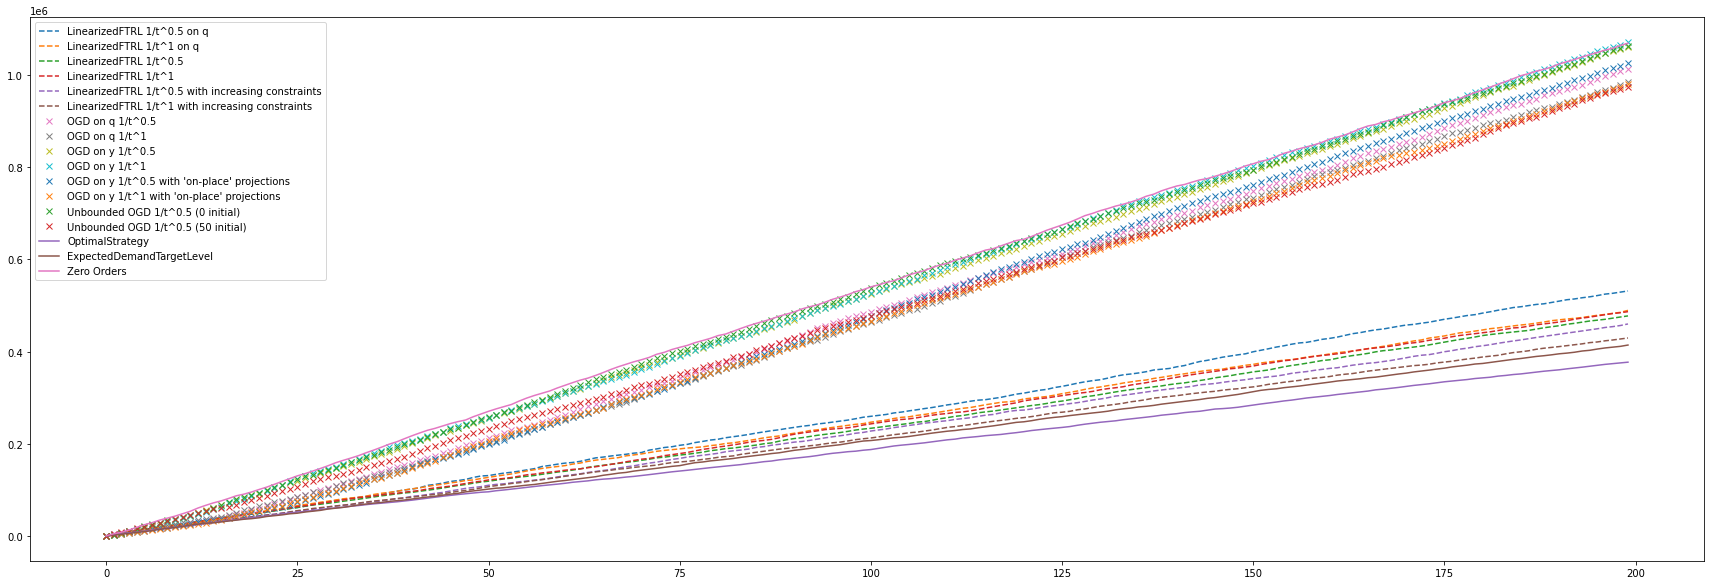

In [ ]:
plt.figure(figsize=(30,10))
for policy_id in range(len(policies)) :
    array = np.array(pd.read_csv("cost_histories/costs_{}.csv".format(policy_id)).groupby("period").sum().sum(axis=1).cumsum())[::10]
    if(policy_id<6) :
        plt.plot(array,"--",label=policies[policy_id])
    elif(policy_id>=6 and policy_id<14) :
        plt.plot(array,"x",label=policies[policy_id])
    else :
        plt.plot(array,label=policies[policy_id])
plt.legend()
plt.show()

Cumulative stockout cost

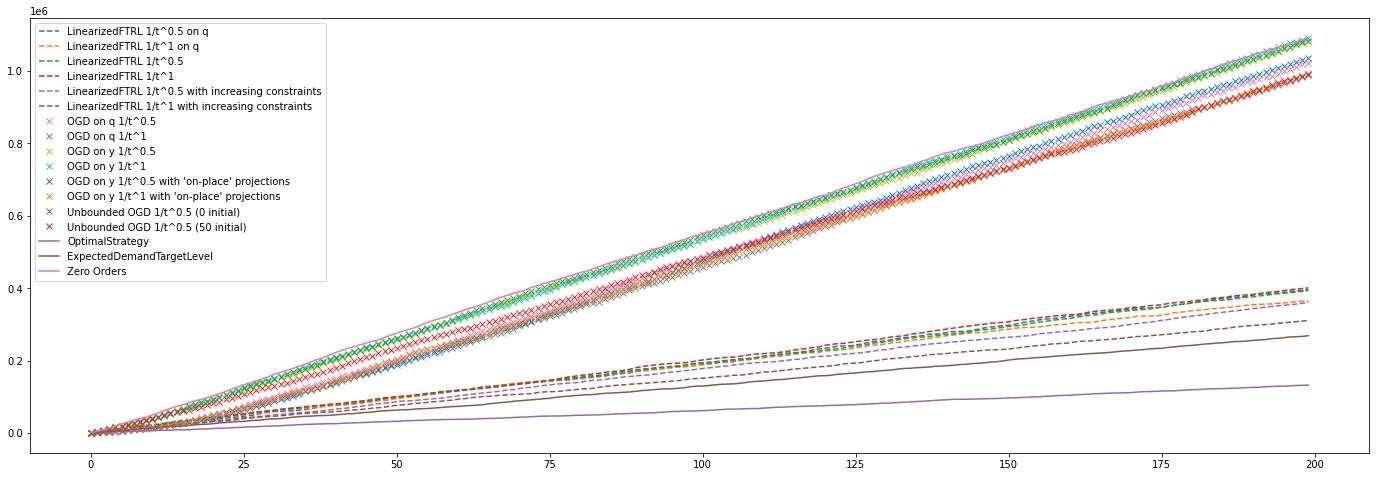

In [ ]:
plt.figure(figsize=(24,8))
for policy_id in range(len(policies)) :
    array = np.array(pd.read_csv("cost_histories/costs_{}.csv".format(policy_id)).groupby("period").sum()["stockout_cost"].cumsum())[::10]
    if(policy_id<6) :
        plt.plot(array,"--",label=policies[policy_id])
    elif(policy_id>=6 and policy_id<14) :
        plt.plot(array,"x",label=policies[policy_id])
    else :
        plt.plot(array,label=policies[policy_id])
plt.legend()
plt.show()

Cumulative holding cost

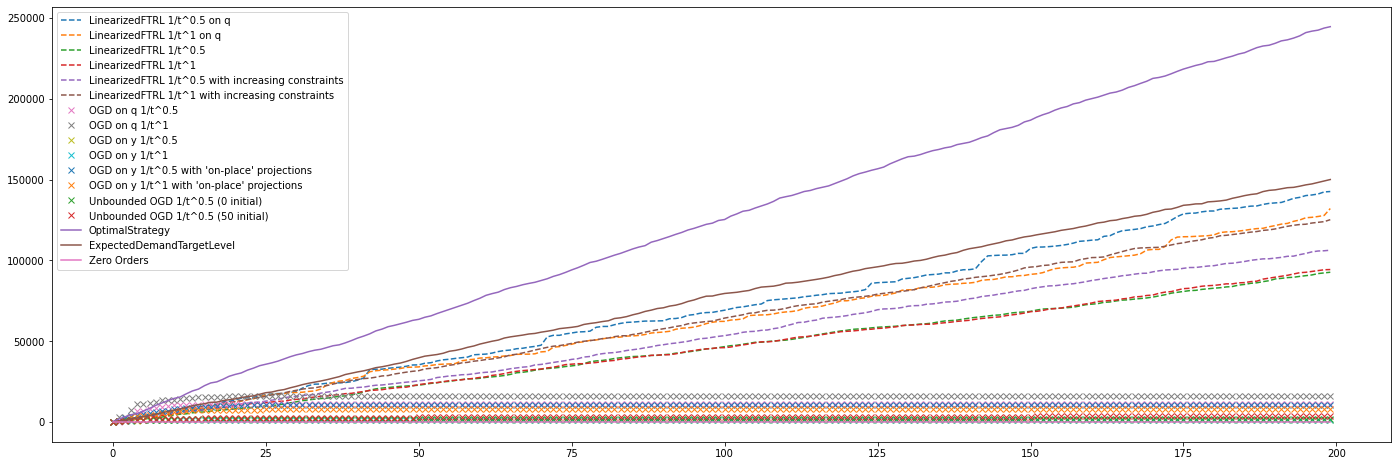

In [ ]:
plt.figure(figsize=(24,8))
for policy_id in range(len(policies)) :
    array = np.array(pd.read_csv("cost_histories/costs_{}.csv".format(policy_id)).groupby("period").sum()["holding_cost"].cumsum())[::10]
    if(policy_id<6) :
        plt.plot(array,"--",label=policies[policy_id])
    elif(policy_id>=6 and policy_id<14) :
        plt.plot(array,"x",label=policies[policy_id])
    else :
        plt.plot(array,label=policies[policy_id])
plt.legend()
plt.show()